# Module 2a - Clip WaPOR data to Area of Interest (AOI)
This Notebook contains the following steps
* Step a - Import modules/libraries
* Step b - Clip WaPOR data to boundary (using shapefile)

**=====================================================================================================================**

![title](https://raw.githubusercontent.com/wateraccounting/WaPORIPA/main/images/Clip_image.png)

**=====================================================================================================================**

Before you start running this Notebook, make sure you have the following information:

*   Seasonal outputs from module 1 (AETI, T, TBP) and module 2 (RET, PCP, potET)

*   Shapefile with the Area of Interest (AOI)

Step a - Import modules/libraries

In [ ]:
!pip install rasterio

In [ ]:
import os
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

Step b - Clip using project boundary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the data to clip

In [69]:
# Define paths
input_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/Seasons2'
input_fhs   = glob.glob(input_folder+ '/*.tif')

shapefile = '/content/drive/MyDrive/WaPOR_IPA/Data/fields/Wad_Hilal_Block_Boundary.shp'

output_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/Clipped'
output_fhs    = glob.glob(output_folder + '/*.tif')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Check raster layer (before clipping to the project area)

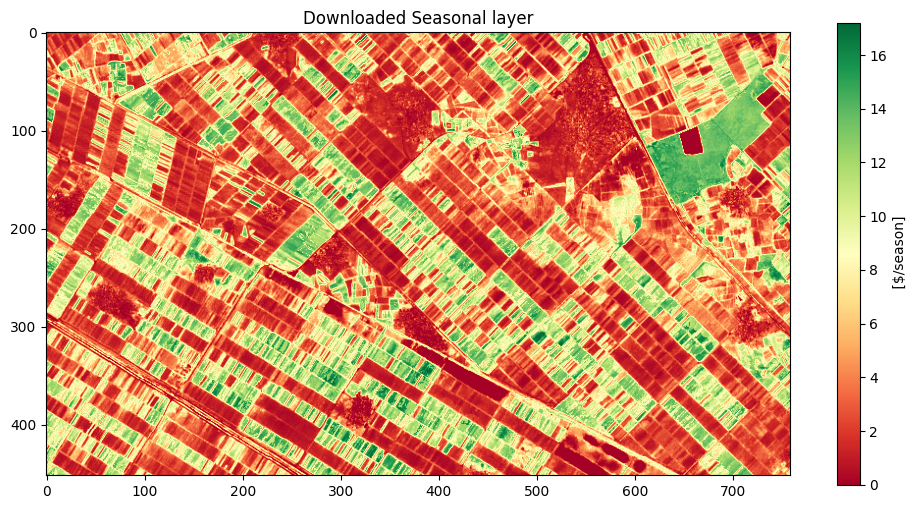

In [77]:
# Open the raster file
Season_tif = rio.open(input_fhs[0])

# Read the first band
Season_data = Season_tif.read(1)

# Plot the data
plt.figure(figsize=(12, 8))
plt.imshow(Season_data, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [$/season]')
plt.title('Downloaded Seasonal layer')
plt.show()

Plot the AOI

''

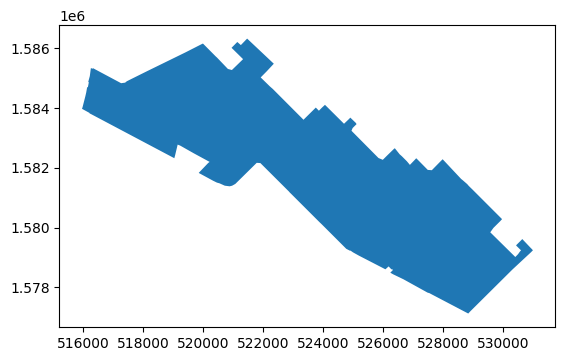

In [97]:
gdf = gpd.read_file(shapefile)
gdf.plot()
gdf
,

In [98]:
# Function to Clip a raster, and reproject the shapefile if projection is different

def reproject_shapefile(shapefile, dst_crs):
    # Read the shapefile
    gdf = gpd.read_file(shapefile)
    # Reproject to the destination CRS
    gdf = gdf.to_crs(dst_crs)
    return gdf

def clip_rasters_with_shapefile(input_folder, shapefile, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read the shapefile
    gdf = gpd.read_file(shapefile)

    clipped_files = []

    for raster_file in os.listdir(input_folder):
        if raster_file.endswith('.tif'):
            raster_path = os.path.join(input_folder, raster_file)
            with rasterio.open(raster_path) as src:
                # Reproject shapefile if needed
                if gdf.crs != src.crs:
                    gdf = reproject_shapefile(shapefile, src.crs)

                # Get the geometry in the format required by rasterio.mask
                shapes = [feature["geometry"] for feature in gdf.__geo_interface__["features"]]

                # Clip the raster
                out_image, out_transform = mask(src, shapes, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "crs": src.crs
                })

                # Save the clipped raster
                output_raster_path = os.path.join(output_folder, raster_file)
                with rasterio.open(output_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)

                clipped_files.append(output_raster_path)

    return clipped_files

In [99]:
# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folder, shapefile, output_folder)

 Check Seasonal raster layer (after clipping to the project area)

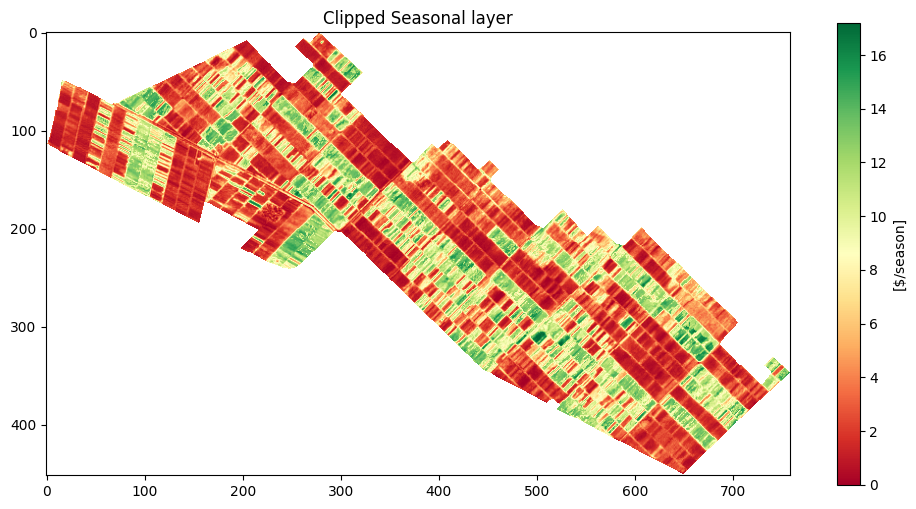

In [100]:
# Open the raster file
with rio.open(output_fhs[0]) as Clipped:
    # Read the first band of the raster data
    Clipped_data = Clipped.read(1)

    # Mask the -9999 values
    Clipped_data = np.ma.masked_equal(Clipped_data, -9999)

# Plot the data
plt.figure(figsize=(12, 8))
plt.imshow(Clipped_data, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label='[$/season]')
plt.title('Clipped Seasonal layer')
plt.show()